In [1]:
import QuantLib as ql
from datetime import datetime

In [ ]:
today = ql.Date(15, 4, 2025)
ql.Settings.instance().evaluationDate = today
# Define SOFR Cap/Floor trade terms
start_date = ql.Date(17, 4, 2025)
maturity_date = ql.Date(17, 4, 2030)
tenor = ql.Period(3, ql.Months)  # Quarterly reset and payment
calendar = ql.UnitedStates(ql.UnitedStates.FederalReserve)
business_convention = ql.ModifiedFollowing
day_count = ql.Actual360()
sofr_curve_handle = ql.RelinkableYieldTermStructureHandle()
sofr_index = ql.Sofr(sofr_curve_handle)

sofr_rates = [(ql.Date(15,4,2025),3.04)]

# add daily USD/SOFR fixing rate
for s_rate in sofr_rates:
    sofr_index.addFixing(s_rate[0], s_rate[1]/100.0)



In [3]:
# Create a schedule
schedule = ql.Schedule(start_date, 
                       maturity_date, 
                       tenor, 
                       calendar, 
                       business_convention, 
                       business_convention,
                       ql.DateGeneration.Forward, 
                       False)

# generate floating SOFR leg
sofr_leg = ql.OvernightLeg([1_000_000], schedule, sofr_index, 
                           paymentConvention=ql.ModifiedFollowing,
                           paymentLag=2)

In [ ]:
# Define the strike rate
strike_rate = 0.03  # 3%

# Create a Cap and Floor
cap = ql.Cap(sofr_leg, [strike_rate])
floor = ql.Floor(sofr_leg, [strike_rate])

In [5]:
# --- Convert to QuantLib Date ---
def to_ql_date(date_str):
    # Parse the date string
    date_obj = datetime.strptime(date_str, "%m/%d/%Y")
    # Convert to QuantLib Date (Month is 1-based in QuantLib)
    return ql.Date(date_obj.day, date_obj.month, date_obj.year)

In [ ]:
import pandas as pd

# Assuming we have SOFR discount curve
df_sofr_curve = pd.read_csv('usd_sofr_curve.csv')
# Apply conversion
df_sofr_curve['QL_Date'] = df_sofr_curve['Date'].apply(to_ql_date)
sofr_curve_dates = df_sofr_curve['QL_Date'].tolist()
sofr_curve_zeros = [value/100 for value in df_sofr_curve['ZeroRate']]
# --- USD SOFR curve (we have bootstraped curve and use them directly) ---
sofr_curve = ql.ZeroCurve(sofr_curve_dates, 
                          sofr_curve_zeros, 
                          ql.Actual365Fixed(), 
                          ql.UnitedStates(ql.UnitedStates.FederalReserve))

sofr_curve_handle.linkTo(sofr_curve)

In [7]:
# Define the Normal (Bachelier) volatility
normal_vol = 0.00246  # 25 bps in absolute terms
normal_vol_handle = ql.QuoteHandle(ql.SimpleQuote(normal_vol))

# Use the Bachelier pricing engine
Bachelier_engine = ql.BachelierCapFloorEngine(sofr_curve_handle, normal_vol_handle)

# Set the pricing engine to the Cap/Floor
cap.setPricingEngine(Bachelier_engine)
floor.setPricingEngine(Bachelier_engine)

# Output the NPV
print(f"Cap Price (Bachelier): {cap.NPV()}")
print(f"Floor Price (Bachelier): {floor.NPV()}")

Cap Price (Bachelier): 43847.44895162852
Floor Price (Bachelier): 948.686740791454


In [8]:
# cap vol quotation
strikes = [0.03, 0.035, 0.04]
expiries = [ql.Period(i, ql.Years) for i in range(1, 11)]
vols = ql.Matrix(len(expiries), len(strikes))
data = [[12.52, 24.73, 26.8],
        [15.81, 24.94, 27.95],
        [18.91, 41.48, 38.94],
        [21, 40.14, 37.17],
        [22.46, 41.69, 38.96],
        [23.39, 43.06, 38.48],
        [23.95, 43.98, 39.61],
        [24.29, 44.58, 39.51],
        [24.42, 44.7, 39.09],
        [24.42, 44.36, 37.41]]
for i in range(vols.rows()):
    for j in range(vols.columns()):
        vols[i][j] = data[i][j]/10000

capfloor_vol = ql.CapFloorTermVolSurface(2, calendar,
                                         business_convention,
                                         expiries,
                                         strikes,
                                         vols,
                                         day_count)


# use class OptionletStripper1 to strip the individual caplet volatilities from the cap vol.
optionlet_surf = ql.OptionletStripper1(capfloor_vol,
                                       sofr_index,
                                       ql.nullDouble(),
                                       1e-6,
                                       100,
                                       sofr_curve_handle,
                                       ql.Normal)

# however, we encounter an error said "undecidable comparison between 10Y and 3650D"
ovs_handle = ql.OptionletVolatilityStructureHandle(ql.StrippedOptionletAdapter(optionlet_surf))

RuntimeError: undecidable comparison between 10Y and 3650D

In [9]:
# but, when I define the SOFR index by class IborIndex with tenor = 3M, then optionlet stripping works now.
sofr_3m = ql.IborIndex('SOFR', ql.Period('3M'), 2,
                        ql.USDCurrency(), calendar, business_convention, 
                        False, day_count, sofr_curve_handle)

# use class OptionletStripper1 to strip the individual caplet volatilities from the cap vol.
optionlet_surf = ql.OptionletStripper1(capfloor_vol,
                                       sofr_3m,
                                       ql.nullDouble(),
                                       1e-6,
                                       100,
                                       sofr_curve_handle,
                                       ql.Normal)

ovs_handle = ql.OptionletVolatilityStructureHandle(ql.StrippedOptionletAdapter(optionlet_surf))

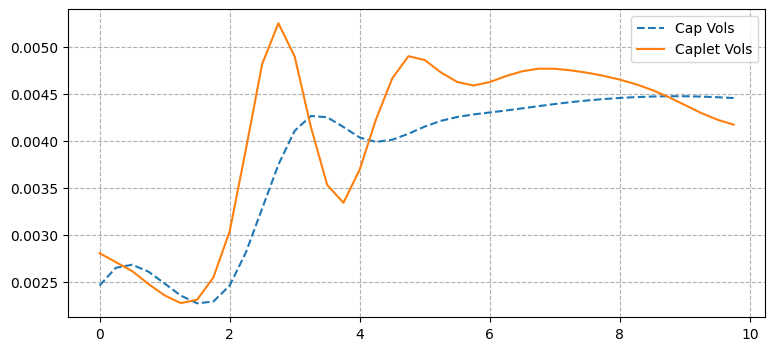

In [10]:
import numpy as np
import matplotlib.pyplot as plt

tenors = np.arange(0, 10, 0.25)
strike = 0.035
cap_vols = [capfloor_vol.volatility(t, strike) for t in tenors]
caplet_vols = [ovs_handle.volatility(t, strike) for t in tenors]

ax = plt.figure(figsize=(9, 4)).add_subplot(1, 1, 1)
ax.plot(tenors, cap_vols, "--", label = 'Cap Vols')
ax.plot(tenors, caplet_vols, "-", label = 'Caplet Vols')
ax.legend(loc='best')
plt.grid(linestyle='--')
plt.show()

In [11]:
engine_ovs = ql.BachelierCapFloorEngine(sofr_curve_handle, ovs_handle)
cap.setPricingEngine(engine_ovs)
# Output the NPV
print(f"Cap Price (Bachelier) by vol surface: {cap.NPV()}")

Cap Price (Bachelier) by vol surface: 43711.19692993242
